# **Import libraries**

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Conv2D, Input, Add, Activation, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential, Model,load_model

from tensorflow import keras as ks
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping

# **Load datasets and preprocessing**
Dataset: Cifar-10

## Load data

In [2]:
(X_train, y_train) , (X_test, y_test) = ks.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
X_train.shape

(50000, 32, 32, 3)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


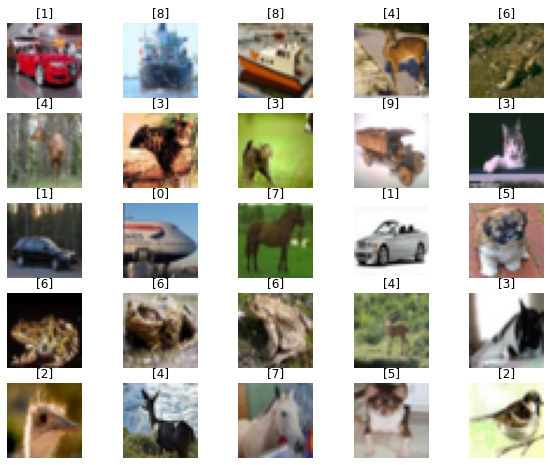

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(X_train.shape[0])
    img, label = X_train[sample_idx],  y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Normalization

In [5]:
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train = X_train / 255.0 
X_test = X_test / 255.0


## One hot encode for labels

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


## Split to get validation data

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.2)


In [8]:
print(X_train.shape)
print(y_train.shape)

(40000, 32, 32, 3)
(40000, 10)


## Define callbacks and constants

In [49]:
lrr = ReduceLROnPlateau(monitor='val_accuracy',   factor=.01,   patience=3,  min_lr=1e-5) 
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

batch_size= 100
epochs=20


## Data generator

In [10]:
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

train_generator.fit(X_train)
val_generator.fit(X_val)
test_generator.fit(X_test)


# **Models**

## **VGG**

In [50]:
VGG = ks.Sequential()

VGG.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv1', input_shape=(32,32, 3)))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.3))
VGG.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv2'))
VGG.add(BatchNormalization())
VGG.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

VGG.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv1'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))
VGG.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv2'))
VGG.add(BatchNormalization())
VGG.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))

VGG.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv1'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv2'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv3'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv1'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv2'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv3'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))

VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv1'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))

VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv2'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.4))


VGG.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv3'))
VGG.add(BatchNormalization())

VGG.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))
VGG.add(Dropout(0.5))


VGG.add(Flatten())
VGG.add(Dense(4096, activation='relu'))
VGG.add(BatchNormalization())
VGG.add(Dropout(0.5))

VGG.add(Dense(4096, activation='relu'))
VGG.add(BatchNormalization())
VGG.add(Dense(10, activation='softmax'))



In [51]:
VGG.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_39 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_40 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 block1_maxpool (MaxPooling2  (None, 16, 16, 64)      

In [52]:
VGG.compile(loss = ks.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


In [54]:
VGG_history = VGG.fit(train_generator.flow(X_train, y_train, batch_size=batch_size), 
                      epochs = epochs, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
                      validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)),
                      callbacks = [es])

Epoch 1/20
400/400 [==============================] - 35s 81ms/step - loss: 2.5394 - accuracy: 0.2143 - val_loss: 5.2924 - val_accuracy: 0.1450
Epoch 2/20
400/400 [==============================] - 32s 79ms/step - loss: 1.9579 - accuracy: 0.3277 - val_loss: 2.0637 - val_accuracy: 0.3201
Epoch 3/20
400/400 [==============================] - 32s 80ms/step - loss: 1.8425 - accuracy: 0.3891 - val_loss: 1.8589 - val_accuracy: 0.4314
Epoch 4/20
400/400 [==============================] - 32s 80ms/step - loss: 1.5740 - accuracy: 0.4527 - val_loss: 1.6266 - val_accuracy: 0.4561
Epoch 5/20
400/400 [==============================] - 32s 81ms/step - loss: 1.4060 - accuracy: 0.5118 - val_loss: 4.9067 - val_accuracy: 0.3726
Epoch 6/20
400/400 [==============================] - 32s 81ms/step - loss: 1.8260 - accuracy: 0.4149 - val_loss: 1.9888 - val_accuracy: 0.4789
Epoch 7/20
400/400 [==============================] - 32s 81ms/step - loss: 1.7489 - accuracy: 0.4320 - val_loss: 1.5455 - val_accuracy:

In [55]:
y_pred_VGG = VGG.predict(X_test)

acc_score = accuracy_score(np.argmax(y_test,axis = 1), np.argmax(y_pred_VGG,axis = 1))
print('VGG accuracy = ', acc_score)

313/313 [==============================] - 3s 9ms/step
VGG accuracy =  0.6879


## **AlexNet**

In [57]:

AlexNet = ks.Sequential()

AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 batch_normalization_54 (Bat  (None, 8, 8, 96)         384       
 chNormalization)                                                
                                                                 
 activation_107 (Activation)  (None, 8, 8, 96)         0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_55 (Bat  (None, 4, 4, 256)       

In [58]:
AlexNet.compile(loss = ks.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


In [59]:
AlexNet_history = AlexNet.fit(train_generator.flow(X_train, y_train, batch_size=batch_size), 
                      epochs = epochs, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
                      validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)), 
                      callbacks = [lrr], verbose=1)


Epoch 1/20
400/400 [==============================] - 28s 64ms/step - loss: 1.6250 - accuracy: 0.4175 - val_loss: 1.9727 - val_accuracy: 0.2865 - lr: 0.0010
Epoch 2/20
400/400 [==============================] - 25s 63ms/step - loss: 1.3743 - accuracy: 0.5167 - val_loss: 1.8818 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 3/20
400/400 [==============================] - 26s 64ms/step - loss: 1.2631 - accuracy: 0.5608 - val_loss: 1.7917 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/20
400/400 [==============================] - 25s 62ms/step - loss: 1.1730 - accuracy: 0.5911 - val_loss: 1.6837 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 5/20
400/400 [==============================] - 25s 61ms/step - loss: 1.0951 - accuracy: 0.6214 - val_loss: 1.4878 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 6/20
400/400 [==============================] - 26s 64ms/step - loss: 1.0343 - accuracy: 0.6438 - val_loss: 1.4120 - val_accuracy: 0.5319 - lr: 0.0010
Epoch 7/20
400/400 [==============================] - 25s 

In [60]:
y_pred_AlexNet =AlexNet.predict(X_test)

acc_score = accuracy_score(np.argmax(y_test,axis = 1), np.argmax(y_pred_AlexNet,axis = 1))
print('AlexNet accuracy = ', acc_score)

313/313 [==============================] - 1s 4ms/step
AlexNet accuracy =  0.7147


## **ResNet**

In [61]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [62]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [63]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model


In [64]:
ResNet = ResNet50(input_shape=(32, 32, 3))


In [65]:
ResNet.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']           

In [66]:
ResNet.compile(loss = ks.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


In [67]:
ResNet_history = ResNet.fit(train_generator.flow(X_train, y_train, batch_size=batch_size), 
                      epochs = epochs, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
                      validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)), 
                      callbacks = [es], verbose=1)


Epoch 1/20
400/400 [==============================] - 45s 98ms/step - loss: 1.7737 - accuracy: 0.3608 - val_loss: 2.1330 - val_accuracy: 0.2829
Epoch 2/20
400/400 [==============================] - 39s 97ms/step - loss: 1.3826 - accuracy: 0.5038 - val_loss: 1.7947 - val_accuracy: 0.4470
Epoch 3/20
400/400 [==============================] - 37s 94ms/step - loss: 1.2799 - accuracy: 0.5436 - val_loss: 1.8322 - val_accuracy: 0.4218
Epoch 4/20
400/400 [==============================] - 40s 100ms/step - loss: 1.0935 - accuracy: 0.6174 - val_loss: 1.2699 - val_accuracy: 0.5637
Epoch 5/20
400/400 [==============================] - 42s 104ms/step - loss: 1.0676 - accuracy: 0.6264 - val_loss: 1.8895 - val_accuracy: 0.3371
Epoch 6/20
400/400 [==============================] - 38s 94ms/step - loss: 1.0114 - accuracy: 0.6452 - val_loss: 1.9979 - val_accuracy: 0.2493
Epoch 7/20
400/400 [==============================] - 37s 93ms/step - loss: 1.0174 - accuracy: 0.6445 - val_loss: 1.4451 - val_accurac

In [68]:
y_pred_ResNet = ResNet.predict(X_test)

acc_score = accuracy_score(np.argmax(y_test,axis = 1), np.argmax(y_pred_ResNet,axis = 1))
print('ResNet accuracy = ', acc_score)

313/313 [==============================] - 5s 14ms/step
ResNet accuracy =  0.7136


# **Analysis**

In [34]:
from matplotlib import pyplot as plt
 
def summarize_diagnostics(history, model_name):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()



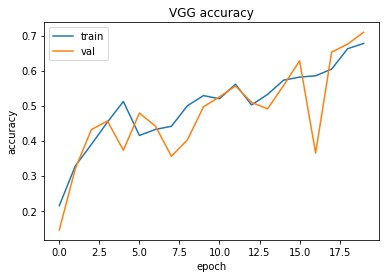

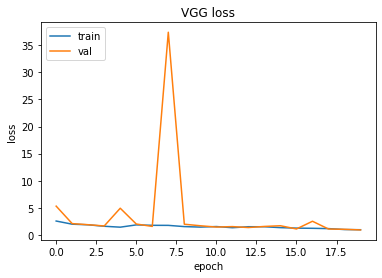

In [56]:
summarize_diagnostics(VGG_history, "VGG")

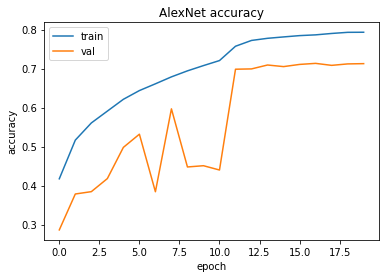

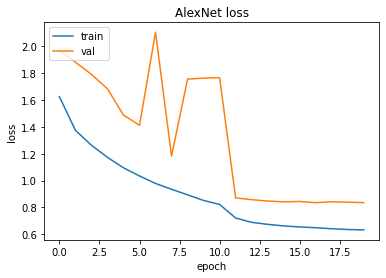

In [69]:
summarize_diagnostics(AlexNet_history, "AlexNet")

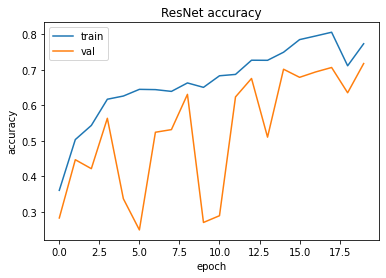

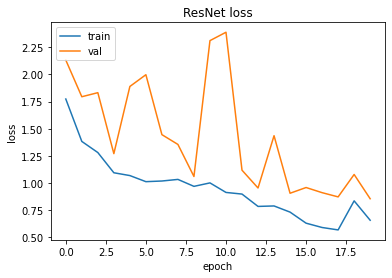

In [70]:
summarize_diagnostics(ResNet_history, "ResNet")